# Summary:
This notebook will cover applying **Named Entity Recognition (NER)** using **spaCy** for tweet sentiment extraction.

# Table of contents
* [1. Data preparation and NER model training](#Part1_link)
<br >&nbsp;&nbsp;&nbsp;[1.1 Neutral tweet](#Part1.1_link)
<br >&nbsp;&nbsp;&nbsp;[1.2 Positive tweet](#Part1.2_link)
<br >&nbsp;&nbsp;&nbsp;[1.3 Negative tweet](#Part1.3_link)
* [2. Model evaluation](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 Neutral tweet](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2 Positive tweet](#Part2.2_link)
<br >&nbsp;&nbsp;&nbsp;[2.3 Negative tweet](#Part2.3_link)
<br >&nbsp;&nbsp;&nbsp;[2.4 Summary](#Part2.4_link)
* [3. Prediction on test datasets](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 Neutral tweet](#Part3.1_link)
<br >&nbsp;&nbsp;&nbsp;[3.2 Positive tweet](#Part3.2_link)
<br >&nbsp;&nbsp;&nbsp;[3.3 Negative tweet](#Part3.3_link)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import spacy
from tqdm import tqdm
import random
from spacy.util import compounding
from spacy.util import minibatch
from nltk.tokenize import sent_tokenize

In [3]:
base_dir="/Volumes/Yuchen_Drive/Tweet_Sentiment_Extraction/tweet-sentiment-extraction"

In [4]:
train_df=pd.read_csv(os.path.join(base_dir,"train.csv"))
test_df=pd.read_csv(os.path.join(base_dir,"test.csv"))
print("training set: {}".format(train_df.shape))
print("testing set: {}".format(test_df.shape))
train_df.dropna(inplace=True)
print("training set after removing NA: {}".format(train_df.shape))

training set: (27481, 4)
testing set: (3534, 3)
training set after removing NA: (27480, 4)


In [5]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


<a id='Part1_link'></a>
# 1. Data preparation and NER model training

<br>https://spacy.io/usage/training#ner
<br>https://www.kaggle.com/rohitsingh9990/ner-training-using-spacy-ensemble

In [5]:
def spacy_ner_train(train_data,model,save_path,n_iter=20,model_name="new_model"):
    '''Load the model, set up the pipeline and train the entity recognizer.'''
    ## https://spacy.io/usage/training#ner
    ## Create/ load the model
    if model:
        nlp=spacy.load(model)
        print("Loaded model: {}".format(model))
    else:
        nlp=spacy.blank("en")
        print("Created blank 'en' model")
    ## create the built-in pipeline components and add them to the pipeline
    ## nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner=nlp.create_pipe("ner")
        nlp.add_pipe(ner,last=True)
    ## otherwise, get it so we can add labels
    else:
        ner=nlp.get_pipe("ner")
    
    ## add labels
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    ## get names of other pipes to disable them during training
    pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        ## reset and initialize the weights randomly – but only if we're training a new model
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()
        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(
                    texts,  # batch of texts
                    annotations,  # batch of annotations
                    drop=0.5,  # dropout - make it harder to memorise data
                    losses=losses,
                )
            print("Losses", losses)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    nlp.meta["name"]=model_name
    nlp.to_disk(save_path)
    print("Saved model to {}".format(save_path))
    

In [6]:
def format_data_ner(sentiment):
    train_data=[]
    for idx,row in train_df.iterrows():
        if row.sentiment==sentiment:
            selected_text=row.selected_text
            text=row.text
            start=text.find(selected_text)
            end=start+len(selected_text)
            train_data.append((text, {"entities":[[start,end,sentiment]]}))
    return train_data

<a id='Part1.1_link'></a>
## 1.1 Neutral tweet

In [37]:
sentiment="neutral"
save_path=os.path.join(base_dir,"spacy_ner_models/tweet_sentiment_spacy_ner_{}".format(sentiment))
train_data=format_data_ner(sentiment)
spacy_ner_train(train_data,model=None,save_path=save_path,n_iter=20,model_name="spacy_ner_neutral")

  0%|          | 0/20 [00:00<?, ?it/s]

Created blank 'en' model


  5%|▌         | 1/20 [00:56<17:52, 56.46s/it]

Losses {'ner': 7232.56836391486}


 10%|█         | 2/20 [01:53<16:59, 56.65s/it]

Losses {'ner': 5420.439400983834}


 15%|█▌        | 3/20 [03:05<17:20, 61.22s/it]

Losses {'ner': 4913.221209207738}


 20%|██        | 4/20 [04:11<16:41, 62.61s/it]

Losses {'ner': 4920.298366672877}


 25%|██▌       | 5/20 [05:18<15:58, 63.90s/it]

Losses {'ner': 5096.758499501369}


 30%|███       | 6/20 [06:21<14:51, 63.65s/it]

Losses {'ner': 4810.55829170448}


 35%|███▌      | 7/20 [07:20<13:31, 62.46s/it]

Losses {'ner': 4670.722851497434}


 40%|████      | 8/20 [08:22<12:25, 62.11s/it]

Losses {'ner': 4595.411507923081}


 45%|████▌     | 9/20 [09:21<11:14, 61.35s/it]

Losses {'ner': 4348.762876765253}


 50%|█████     | 10/20 [10:24<10:16, 61.61s/it]

Losses {'ner': 4271.493232258368}


 55%|█████▌    | 11/20 [11:26<09:17, 61.96s/it]

Losses {'ner': 4180.200527508218}


 60%|██████    | 12/20 [12:34<08:30, 63.80s/it]

Losses {'ner': 3975.7210370488942}


 65%|██████▌   | 13/20 [13:52<07:55, 67.96s/it]

Losses {'ner': 4144.540383581263}


 70%|███████   | 14/20 [15:18<07:20, 73.45s/it]

Losses {'ner': 4070.7134557209934}


 75%|███████▌  | 15/20 [16:40<06:19, 75.90s/it]

Losses {'ner': 3951.7922753662356}


 80%|████████  | 16/20 [17:52<04:58, 74.62s/it]

Losses {'ner': 3786.2081119434283}


 85%|████████▌ | 17/20 [19:01<03:39, 73.08s/it]

Losses {'ner': 3783.877520813925}


 90%|█████████ | 18/20 [20:15<02:26, 73.22s/it]

Losses {'ner': 3749.1644023361187}


 95%|█████████▌| 19/20 [21:25<01:12, 72.48s/it]

Losses {'ner': 3818.9150552255023}


100%|██████████| 20/20 [22:35<00:00, 67.75s/it]

Losses {'ner': 3512.037882850722}


Saved model to /Volumes/Yuchen_Drive/Tweet_Sentiment_Extraction/tweet-sentiment-extraction/spacy_ner_models/tweet_sentiment_spacy_ner_neutral


<a id='Part1.2_link'></a>
## 1.2 Positive tweet

In [20]:
sentiment="positive"
save_path=os.path.join(base_dir,"spacy_ner_models/tweet_sentiment_spacy_ner_{}".format(sentiment))
train_data=format_data_ner(sentiment)
spacy_ner_train(train_data,model=None,save_path=save_path,n_iter=20,model_name="spacy_ner_positive")

  0%|          | 0/20 [00:00<?, ?it/s]

Created blank 'en' model


  5%|▌         | 1/20 [00:47<15:09, 47.87s/it]

Losses {'ner': 34707.03441502922}


 10%|█         | 2/20 [01:35<14:20, 47.78s/it]

Losses {'ner': 31410.8104673023}


 15%|█▌        | 3/20 [02:23<13:33, 47.85s/it]

Losses {'ner': 29453.56804960462}


 20%|██        | 4/20 [03:11<12:46, 47.91s/it]

Losses {'ner': 29116.0934200786}


 25%|██▌       | 5/20 [04:02<12:14, 48.98s/it]

Losses {'ner': 27449.472864216143}


 30%|███       | 6/20 [04:52<11:27, 49.11s/it]

Losses {'ner': 27016.945480483064}


 35%|███▌      | 7/20 [05:39<10:30, 48.52s/it]

Losses {'ner': 27170.30551327591}


 40%|████      | 8/20 [06:33<10:02, 50.17s/it]

Losses {'ner': 26430.796638039184}


 45%|████▌     | 9/20 [07:30<09:33, 52.18s/it]

Losses {'ner': 25872.83003002895}


 50%|█████     | 10/20 [08:30<09:03, 54.40s/it]

Losses {'ner': 25285.949429822867}


 55%|█████▌    | 11/20 [09:29<08:22, 55.83s/it]

Losses {'ner': 25074.582478538283}


 60%|██████    | 12/20 [10:27<07:32, 56.61s/it]

Losses {'ner': 24425.37760106677}


 65%|██████▌   | 13/20 [11:29<06:46, 58.13s/it]

Losses {'ner': 23760.0469047527}


 70%|███████   | 14/20 [12:27<05:49, 58.27s/it]

Losses {'ner': 23748.753083947202}


 75%|███████▌  | 15/20 [13:24<04:49, 57.84s/it]

Losses {'ner': 23591.65825939209}


 80%|████████  | 16/20 [14:22<03:51, 57.88s/it]

Losses {'ner': 23416.57392986379}


 85%|████████▌ | 17/20 [15:20<02:53, 57.73s/it]

Losses {'ner': 23273.38236771614}


 90%|█████████ | 18/20 [16:15<01:53, 56.97s/it]

Losses {'ner': 22699.096169544442}


 95%|█████████▌| 19/20 [17:10<00:56, 56.31s/it]

Losses {'ner': 22525.159630564114}


100%|██████████| 20/20 [18:04<00:00, 54.23s/it]

Losses {'ner': 22052.363353146997}
Saved model to /Volumes/Yuchen_Drive/Tweet_Sentiment_Extraction/tweet-sentiment-extraction/spacy_ner_models/tweet_sentiment_spacy_ner_positive


<a id='Part1.3_link'></a>
## 1.3 Negative tweet

In [42]:
sentiment="negative"
save_path=os.path.join(base_dir,"spacy_ner_models/tweet_sentiment_spacy_ner_{}".format(sentiment))
train_data=format_data_ner(sentiment)
spacy_ner_train(train_data,model=None,save_path=save_path,n_iter=20,model_name="spacy_ner_negative")

  0%|          | 0/20 [00:00<?, ?it/s]

Created blank 'en' model


  5%|▌         | 1/20 [00:49<15:37, 49.35s/it]

Losses {'ner': 32439.384312320966}


 10%|█         | 2/20 [01:36<14:34, 48.61s/it]

Losses {'ner': 28876.801738506347}


 15%|█▌        | 3/20 [02:25<13:48, 48.72s/it]

Losses {'ner': 27879.254559544846}


 20%|██        | 4/20 [03:16<13:10, 49.42s/it]

Losses {'ner': 25888.69089134752}


 25%|██▌       | 5/20 [04:14<13:00, 52.06s/it]

Losses {'ner': 25187.369938425123}


 30%|███       | 6/20 [05:06<12:06, 51.91s/it]

Losses {'ner': 24513.46061063986}


 35%|███▌      | 7/20 [05:57<11:14, 51.87s/it]

Losses {'ner': 23579.895518448335}


 40%|████      | 8/20 [06:49<10:20, 51.75s/it]

Losses {'ner': 23067.518020600917}


 45%|████▌     | 9/20 [07:47<09:51, 53.76s/it]

Losses {'ner': 22632.069989180378}


 50%|█████     | 10/20 [08:46<09:13, 55.31s/it]

Losses {'ner': 21766.24143478606}


 55%|█████▌    | 11/20 [09:41<08:17, 55.29s/it]

Losses {'ner': 21492.149672531938}


 60%|██████    | 12/20 [10:38<07:24, 55.61s/it]

Losses {'ner': 20815.291663881384}


 65%|██████▌   | 13/20 [11:33<06:28, 55.54s/it]

Losses {'ner': 21006.097795342004}


 70%|███████   | 14/20 [12:26<05:27, 54.66s/it]

Losses {'ner': 20605.163635655394}


 75%|███████▌  | 15/20 [13:15<04:25, 53.13s/it]

Losses {'ner': 20636.561557018947}


 80%|████████  | 16/20 [14:08<03:32, 53.01s/it]

Losses {'ner': 19804.9711722716}


 85%|████████▌ | 17/20 [15:00<02:38, 52.73s/it]

Losses {'ner': 19700.763607214565}


 90%|█████████ | 18/20 [15:51<01:44, 52.26s/it]

Losses {'ner': 19550.629343293218}


 95%|█████████▌| 19/20 [16:43<00:51, 51.97s/it]

Losses {'ner': 19348.781906343975}


100%|██████████| 20/20 [17:34<00:00, 52.71s/it]

Losses {'ner': 19202.155455397897}
Saved model to /Volumes/Yuchen_Drive/Tweet_Sentiment_Extraction/tweet-sentiment-extraction/spacy_ner_models/tweet_sentiment_spacy_ner_negative


<a id='Part2_link'></a>
# 2. Model evaluation

In [10]:
def spacy_ner_predict(text,model_path):
    model=spacy.load(model_path)
    doc=model(text)
    ent_list=[]
    for ent in doc.ents:
        start=text.find(ent.text)
        end=start+len(ent.text)
        new_int=[start,end,ent.label_]
        if new_int not in ent_list:
            ent_list.append(new_int)
    selected_text=text[ent_list[0][0]:ent_list[0][1]] if len(ent_list)>0 else text
    return selected_text

In [11]:
def compute_jaccard_similarity(sent1,sent2):
    sents1=sent_tokenize(str(sent1).lower().strip())
    sents2=sent_tokenize(str(sent2).lower().strip())
    a=set()
    for sent in sents1:
        tokens=sent.split()
        a=a.union(set(tokens))
    b=set()
    for sent in sents2:
        tokens=sent.split()
        b=b.union(set(tokens))
    return len(a.intersection(b))/len(a.union(b))

<a id='Part2.1_link'></a>
## 2.1 Neutral tweet

In [16]:
sentiment="neutral"
model_neutral_path=os.path.join(base_dir,"spacy_ner_models/tweet_sentiment_spacy_ner_{}".format(sentiment))
nlp=spacy.load(model_neutral_path)
train_neutral_df=train_df[train_df.sentiment=="neutral"]
test_neutral_df=test_df[test_df.sentiment=="neutral"]

In [39]:
tqdm.pandas()
train_neutral_df["spacy_ner_predict"]=train_neutral_df.text.progress_apply(lambda x:spacy_ner_predict(x,model_neutral_path))
train_neutral_df["spacy_ner_jaccard"]=train_neutral_df.progress_apply(lambda x:compute_jaccard_similarity(x.selected_text,x["spacy_ner_predict"]),axis=1)


/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 11117/11117 [1:28:38<00:00,  2.09it/s]
/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 11117/11117 [00:02<00:00, 4644.86it/s]
/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

Text(0.5, 1.0, 'Jaccard similarity score between prediction and selected text for neutral tweet')

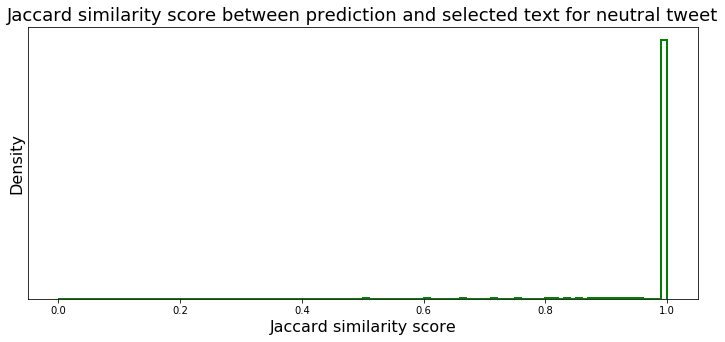

In [11]:
plt.figure(figsize=(12,5))
plt.hist(train_neutral_df["spacy_ner_jaccard"],bins=100,color="green",histtype="step",label="neutral",linewidth=2)
plt.xlabel("Jaccard similarity score",fontsize=16)
plt.yticks([])
plt.ylabel("Density",fontsize=16)
plt.title("Jaccard similarity score between prediction and selected text for neutral tweet",fontsize=18)

<a id='Part2.2_link'></a>
## 2.2 Positive tweet

In [29]:
sentiment="positive"
model_positive_path=os.path.join(base_dir,"spacy_ner_models/tweet_sentiment_spacy_ner_{}".format(sentiment))
train_positive_df=train_df[train_df.sentiment=="positive"]
test_positive_df=test_df[test_df.sentiment=="positive"]

In [32]:
tqdm.pandas()
train_positive_df["spacy_ner_predict"]=train_positive_df.text.progress_apply(lambda x:spacy_ner_predict(x,model_positive_path))
train_positive_df["spacy_ner_jaccard"]=train_positive_df.progress_apply(lambda x:compute_jaccard_similarity(x.selected_text,x["spacy_ner_predict"]),axis=1)


/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 8582/8582 [00:01<00:00, 6681.40it/s]
/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Jaccard similarity score between prediction and selected text for positive tweet')

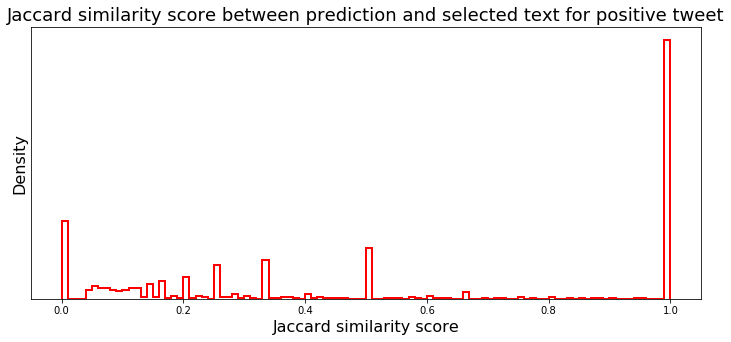

In [14]:
plt.figure(figsize=(12,5))
plt.hist(train_positive_df["spacy_ner_jaccard"],bins=100,color="red",histtype="step",label="positive",linewidth=2)
plt.xlabel("Jaccard similarity score",fontsize=16)
plt.yticks([])
plt.ylabel("Density",fontsize=16)
plt.title("Jaccard similarity score between prediction and selected text for positive tweet",fontsize=18)

<a id='Part2.3_link'></a>
## 2.3 Negative tweet

In [20]:
sentiment="negative"
model_negative_path=os.path.join(base_dir,"spacy_ner_models/tweet_sentiment_spacy_ner_{}".format(sentiment))
nlp=spacy.load(model_negative_path)
train_negative_df=train_df[train_df.sentiment=="negative"]
test_negative_df=test_df[test_df.sentiment=="negative"]

In [44]:
tqdm.pandas()
train_negative_df["spacy_ner_predict"]=train_negative_df.text.progress_apply(lambda x:spacy_ner_predict(x,model_negative_path))
train_negative_df["spacy_ner_jaccard"]=train_negative_df.progress_apply(lambda x:compute_jaccard_similarity(x.selected_text,x["spacy_ner_predict"]),axis=1)


/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 7781/7781 [58:41<00:00,  2.21it/s]  
/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 7781/7781 [00:01<00:00, 6976.67it/s]
/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

Text(0.5, 1.0, 'Jaccard similarity score between prediction and selected text for negative tweet')

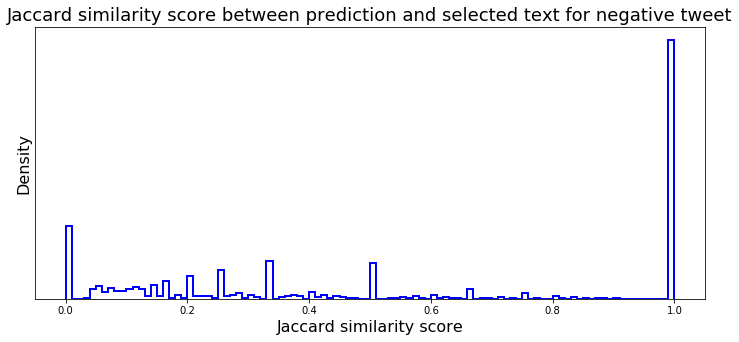

In [15]:
plt.figure(figsize=(12,5))
plt.hist(train_negative_df["spacy_ner_jaccard"],bins=100,color="blue",histtype="step",label="negative",linewidth=2)
plt.xlabel("Jaccard similarity score",fontsize=16)
plt.yticks([])
plt.ylabel("Density",fontsize=16)
plt.title("Jaccard similarity score between prediction and selected text for negative tweet",fontsize=18)

In [47]:
train_positive_df.to_csv(os.path.join("spacy_ner_models/train_positive_df.csv"),index=False)
train_neutral_df.to_csv(os.path.join("spacy_ner_models/train_neutral_df.csv"),index=False)
train_negative_df.to_csv(os.path.join("spacy_ner_models/train_negative_df.csv"),index=False)

In [8]:
train_neutral_df=pd.read_csv(os.path.join(base_dir,"spacy_ner_models/train_neutral_df.csv"))
train_positive_df=pd.read_csv(os.path.join(base_dir,"spacy_ner_models/train_positive_df.csv"))
train_negative_df=pd.read_csv(os.path.join(base_dir,"spacy_ner_models/train_negative_df.csv"))

In [18]:
train_pred_df=pd.concat([train_neutral_df,train_positive_df,train_negative_df],axis=0)
print(train_pred_df.shape)
train_pred_df.head()

(27480, 6)


,textID,text,selected_text,sentiment,spacy_ner_predict,spacy_ner_jaccard
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"I`d have responded, if I were going",1.0
1,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,http://www.dothebouncy.com/smf - some shameles...,1.0
2,50e14c0bb8,Soooo high,Soooo high,neutral,Soooo high,1.0
3,e050245fbd,Both of you,Both of you,neutral,Both of you,1.0
4,2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral,"as much as i love to be hopeful, i reckon the ...",1.0


In [43]:
train_pred_df.to_csv(os.path.join(base_dir,"spacy_ner_models/train_spacy_ner_predict.csv"),index=False)

<a id='Part2.4_link'></a>
## 2.4 Summary

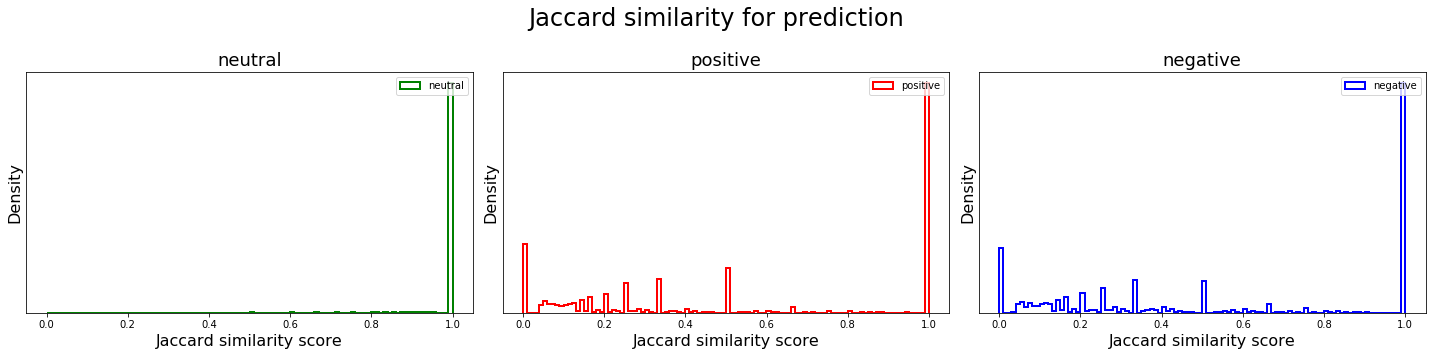

In [22]:
fig,axes=plt.subplots(1,3,figsize=(20,5))
sentiments=["neutral","positive","negative"]
colors=["green","red","blue"]
for i in range(3):
    sentiment=sentiments[i]
    axes[i].hist(train_pred_df[train_pred_df.sentiment==sentiment].spacy_ner_jaccard,bins=100,histtype="step",color=colors[i],density=True,label=sentiment,linewidth=2)
    axes[i].set_xlabel("Jaccard similarity score",fontsize=16)
    axes[i].set_yticks([])
    axes[i].set_ylabel("Density",fontsize=16)
    axes[i].set_title(sentiment,fontsize=18)
    axes[i].legend()
fig.suptitle("Jaccard similarity for prediction",fontsize=24)
plt.tight_layout()
fig.subplots_adjust(top=0.8)

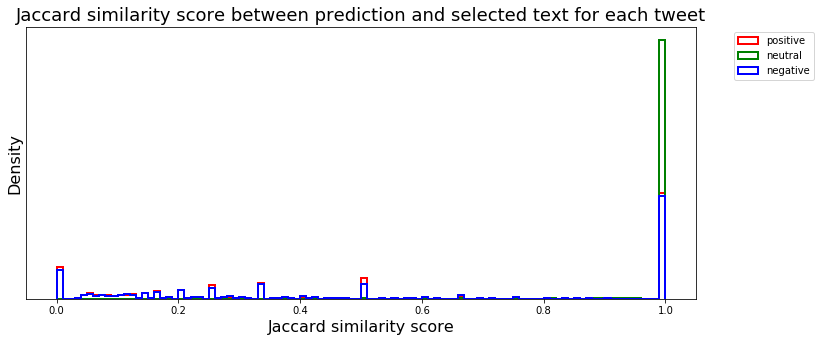

In [16]:
plt.figure(figsize=(12,5))
plt.hist(train_positive_df["spacy_ner_jaccard"],bins=100,histtype="step",color="red",density=True,label="positive",linewidth=2)
plt.hist(train_neutral_df["spacy_ner_jaccard"],bins=100,histtype="step",color="green",density=True,label="neutral",linewidth=2)
plt.hist(train_negative_df["spacy_ner_jaccard"],bins=100,histtype="step",color="blue",density=True,label="negative",linewidth=2)
plt.xlabel("Jaccard similarity score",fontsize=16)
plt.yticks([])
plt.ylabel("Density",fontsize=16)
plt.title("Jaccard similarity score between prediction and selected text for each tweet",fontsize=18)
plt.legend(bbox_to_anchor=(1.05,1))

<a id='Part3_link'></a>
# 3. Prediction on test datasets

<a id='Part3.1_link'></a>
## 3.1 Neutral tweet

In [17]:
tqdm.pandas()
test_neutral_df["spacy_ner_predict"]=test_neutral_df.text.progress_apply(lambda x:spacy_ner_predict(x,model_neutral_path))


/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1430/1430 [10:31<00:00,  2.26it/s]
/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
test_neutral_df.head()

,textID,text,sentiment,spacy_ner_predict
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,Last session of the day
8,e64208b4ef,and within a short time of the last clue all ...,neutral,and within a short time of the last clue all o...
9,37bcad24ca,What did you get? My day is alright.. haven`...,neutral,What did you get? My day is alright.. haven`t...
11,43b390b336,I checked. We didn`t win,neutral,I checked. We didn`t win
12,69d6b5d93e,.. and you`re on twitter! Did the tavern bore...,neutral,.. and you`re on twitter! Did the tavern bore ...


<a id='Part3.2_link'></a>
## 3.2 Positive tweet

In [12]:
tqdm.pandas()
test_positive_df["spacy_ner_predict"]=test_positive_df.text.progress_apply(lambda x:spacy_ner_predict(x,model_positive_path))


100%|██████████| 1103/1103 [08:53<00:00,  2.07it/s]
/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
test_positive_df.head()

,textID,text,sentiment,spacy_ner_predict
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,exciting
3,01082688c6,happy bday!,positive,happy
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,I like it!!
5,726e501993,that`s great!! weee!! visitors!,positive,that`s great!!
18,33f19050cf,you guys didn`t say hi or answer my questions...,positive,nice


<a id='Part3.3_link'></a>
## 3.3 Negative tweet

In [21]:
tqdm.pandas()
test_negative_df["spacy_ner_predict"]=test_negative_df.text.progress_apply(lambda x:spacy_ner_predict(x,model_negative_path))


/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1001/1001 [07:29<00:00,  2.23it/s]
/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
test_negative_df.head()

,textID,text,sentiment,spacy_ner_predict
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,such a shame!
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol,negative,I THINK EVERYONE HATES ME ON HERE lol
7,afa11da83f,"soooooo wish i could, but im in school and my...",negative,blocked
10,24c92644a4,My bike was put on hold...should have known th...,negative,bummer
13,5c1e0b61a1,"I`m in VA for the weekend, my youngest son tur...",negative,"it makes me kinda sad,"


In [23]:
preds_df=pd.concat([test_positive_df,test_neutral_df,test_negative_df],axis=0)

In [24]:
print(preds_df.shape)
preds_df.head()

(3534, 4)


,textID,text,sentiment,spacy_ner_predict
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,exciting
3,01082688c6,happy bday!,positive,happy
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,I like it!!
5,726e501993,that`s great!! weee!! visitors!,positive,that`s great!!
18,33f19050cf,you guys didn`t say hi or answer my questions...,positive,nice


In [45]:
preds_df.to_csv(os.path.join(base_dir,"spacy_ner_models/test_spacy_ner_predict.csv"))

In [28]:
preds_df2=preds_df.loc[:,["textID","spacy_ner_predict"]].rename(columns={"spacy_ner_predict":"selected_text"})
#preds_df2.head()
preds_df2.to_csv(os.path.join(base_dir,"spacy_ner_models/submission1.csv"),index=False)